In [1]:
import numpy as np
import pandas as pd
import pathlib, os, math
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
from matplotlib.lines import Line2D
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Experiment

### Items (m): 100
### Samples (s_samples): 100
### Noise runs (n_runs): 100


## Tested each sample for 3 group-sensitive metrics for each group, across 3 key error std devs (0, 1, and 2), with perfectly independent errors as well as perfectly correlated errors.

### The sample is 30% Asian, but only the metrics for white and Black are displayed in this notebook. This is to preview the metrics to be performed on the next batch of synthetic data which will only have w and b as races.

In [2]:
s_samples=100

# Array of error correlations
err_corrs=[0.0, 1.0]

# Array of error standard deviations
err_sds=[0.0, 1.0, 2.0]

# Array of metrics names
metrics=["subgroup_kt", "change_in_cond_exp_rank", "change_in_rkl"]

# Array of identity groups
#id_groups=["wm", "bm", "wf", "bf", "m", "f", "w", "b", "am", "af", "a"]
id_groups = ['wm', 'bm', 'wf', 'bf', 'm', 'f', 'w', 'b']

In [3]:
base_repo_dir = pathlib.Path(os.getcwd()).parents[1]

In [4]:
groups_dir = base_repo_dir / 'out' / 'distance_metrics' / 'inter_corr' / 'groups'

In [5]:
def metric_boxplots(m, err_sds, id_groups, groups_dir):
    
    cf_dict = {0: 'Noise', 
          1: 'Non-Resolving X',
          2: 'Resolving X'}

    w = 0.3
    move = 0.17
    
    metric_dict={"subgroup_kt": "Sub-Group\nKendall\'s Tau", 
             "change_in_cond_exp_rank": "Change in\nNormalized\nE(rank|group)", 
             "change_in_rkl": "Change in\nNormalized\nDiscounted\nKL-divergence"}
    
    fig, ax = plt.subplots(3, 3, figsize=(18,12), dpi=100, sharey=True) 


    noise_ind = np.zeros([len(err_sds), len(id_groups), s_samples])
    nonres_ind = np.zeros([len(err_sds), len(id_groups), s_samples])
    xres_ind = np.zeros([len(err_sds), len(id_groups), s_samples])

    noise_corr = np.zeros([len(err_sds), len(id_groups), s_samples])
    nonres_corr = np.zeros([len(err_sds), len(id_groups), s_samples])
    xres_corr = np.zeros([len(err_sds), len(id_groups), s_samples])
    
    for s, sd in enumerate(err_sds):
        for g, group in enumerate(id_groups):
            
            # Invert change in expected rank
            flip=1
            if m=='change_in_cond_exp_rank':
                flip=-1
            
            cf_ind = pd.read_pickle(groups_dir/group/m/'counterfactuals'/'corr_0.0_sd_{}.pkl'\
                                                    .format(sd), compression='gzip')

            noise_ind[s][g] = flip*cf_ind['exp_orig_noise']
            nonres_ind[s][g] = flip*cf_ind['orig_nonres_bf']
            xres_ind[s][g] = flip*cf_ind['orig_xres_bf']

            cf_corr = pd.read_pickle(groups_dir/group/m/'counterfactuals'/'corr_1.0_sd_{}.pkl'\
                                                    .format(sd), compression='gzip')

            noise_corr[s][g] = flip*cf_corr['exp_orig_noise']
            nonres_corr[s][g] = flip*cf_corr['orig_nonres_bf']
            xres_corr[s][g] = flip*cf_corr['orig_xres_bf']
            

        ax[0][s].boxplot(noise_ind[s].T,
                         positions = np.arange(len(id_groups))-move, widths=w)
        ax[0][s].boxplot(noise_corr[s].T, labels=id_groups, patch_artist=True,
                        positions = np.arange(len(id_groups))+move, widths=w)

        ax[1][s].boxplot(nonres_ind[s].T, 
                         positions = np.arange(len(id_groups))-move, widths=w)
        ax[1][s].boxplot(nonres_corr[s].T, labels=id_groups, patch_artist=True, 
                        positions = np.arange(len(id_groups))+move, widths=w)

        ax[2][s].boxplot(xres_ind[s].T, 
                         positions = np.arange(len(id_groups))-move, widths=w)
        ax[2][s].boxplot(xres_corr[s].T, labels=id_groups, patch_artist=True, 
                         positions = np.arange(len(id_groups))+move, widths=w)

    for i in range(3):
        ax[i][0].set_ylabel(metric_dict[m], rotation=90, fontsize=18)
        ax[i][0].text(-3, 0.5, cf_dict[i], fontsize=18, ha='right', weight='bold')
        
        for j in range(len(err_sds)):
            ax[i][j].set_xticks(np.arange(len(id_groups)))
            ax[i][j].set_xticklabels(id_groups, fontsize=18, ha='center')
            ax[i][j].spines['right'].set_visible(False)
            ax[i][j].spines['top'].set_visible(False)
            #ax[i][j].spines['bottom'].set_visible(False)
            #ax[i][j].spines['left'].set_visible(False)
            ax[i][j].grid(which='major', alpha=0.5)
            ax[i][j].tick_params(left=False, bottom=False)
            ax[0][j].set_title('Error Node Std. Dev = {}\n\n'.format(err_sds[j]), fontsize=18, weight='bold')
        
    plt.show()
    
    display(Markdown('**White background: independent error terms**'))
    display(Markdown('**Blue background:  perfectly correlated error terms**'))


## Sub-Group Kendall's Tau

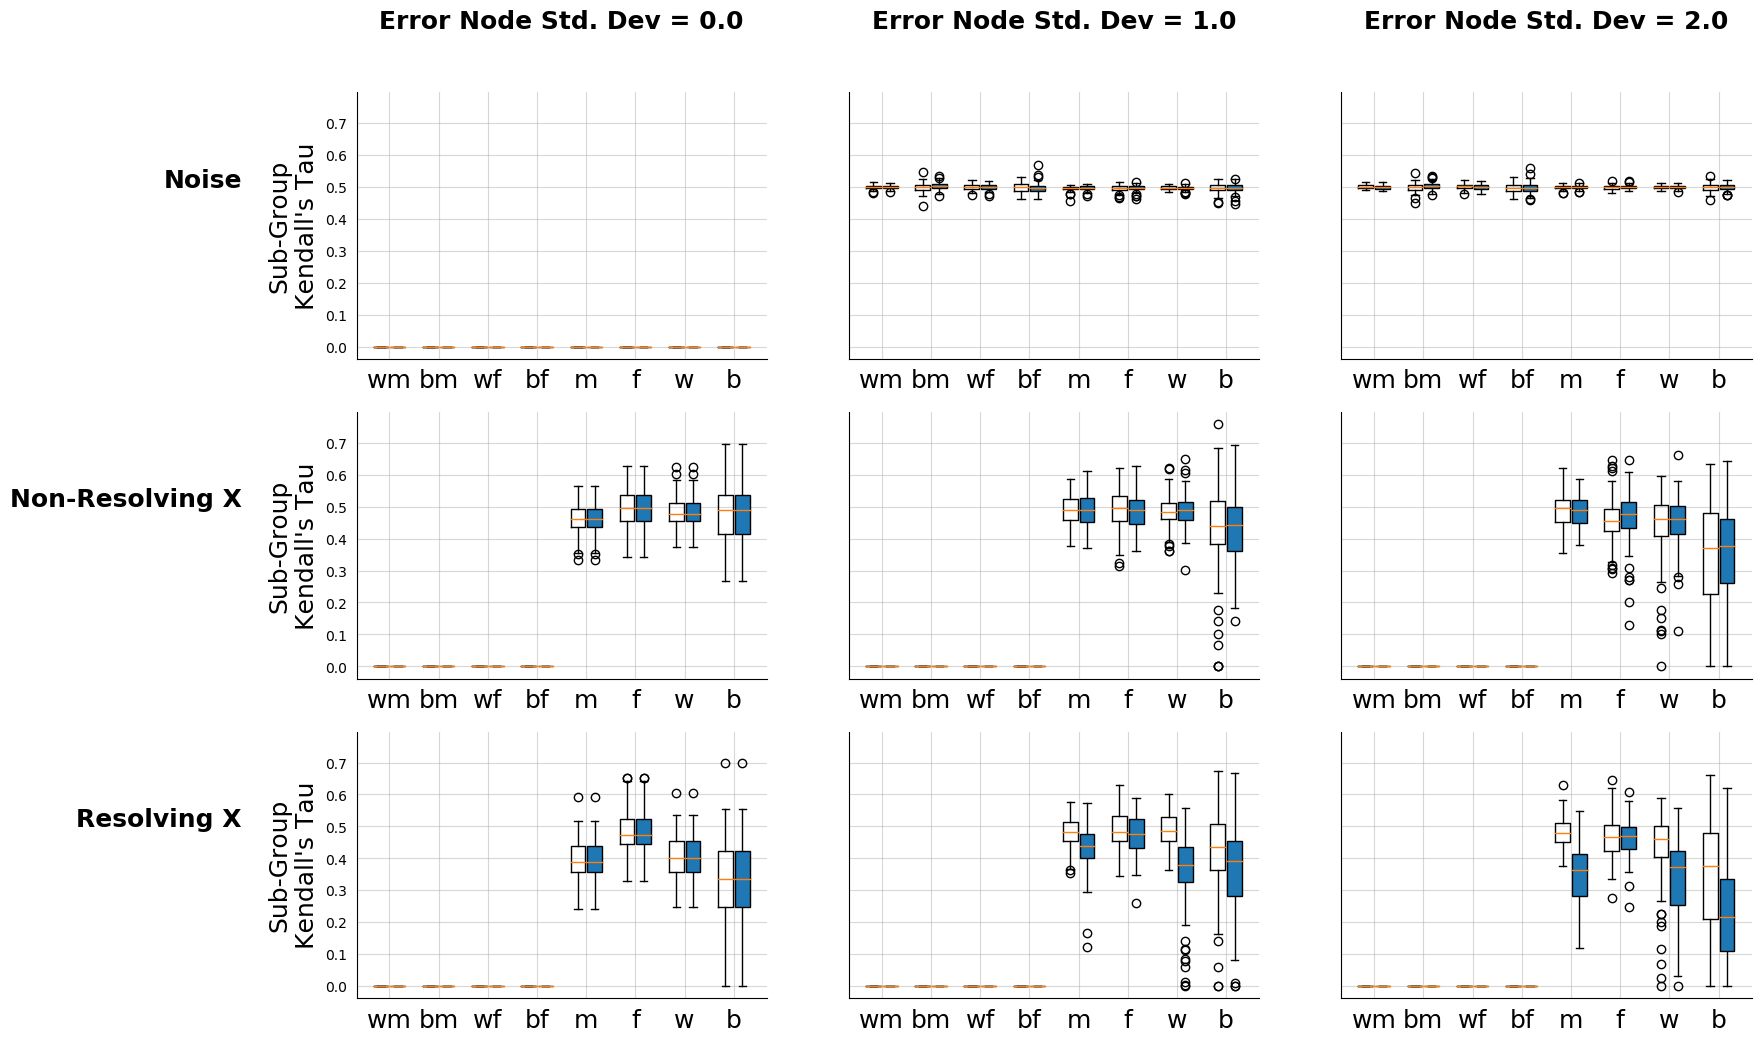

**White background: independent error terms**

**Blue background:  perfectly correlated error terms**

In [6]:
metric_boxplots(metrics[0], err_sds, id_groups, groups_dir)

#### Question on Sub-Group KT: 
    
- Are the counterfactual distances being somehow anchored to 0 for race (w and b)?
- Counterfactuals for intersectional groups always at 0 because of the way counterfactuals are calculated. Should these be removed from the chart?
- Do we want to add IGF Ratio or would that be redundant?

## Change in Normalized Expected Conditional Rank

### E(rank|group]/m_rows - E(rank in original sample|group]/m_rows.  Results multiplied by -1 so that +1 represents an expected move from the bottom spot (rank m) to the top spot (rank 1).

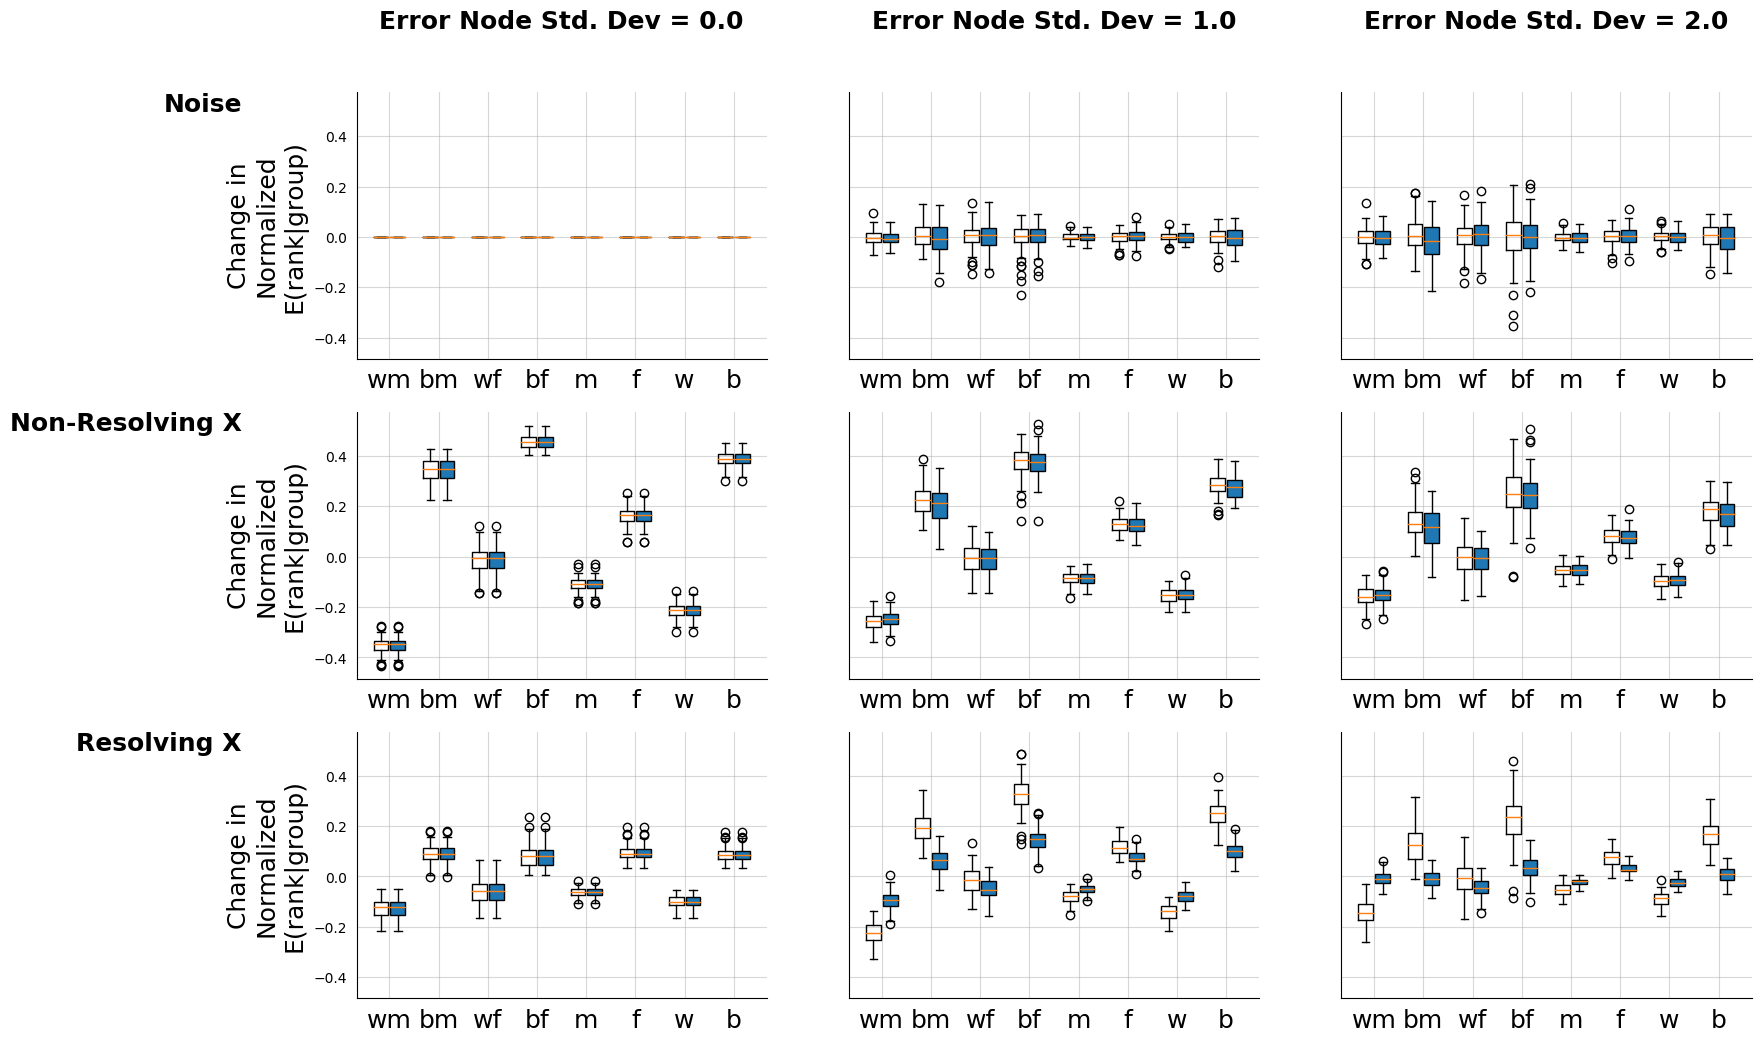

**White background: independent error terms**

**Blue background:  perfectly correlated error terms**

In [7]:
metric_boxplots(metrics[1], err_sds, id_groups, groups_dir)

#### Question on conditional expected rank: 
    
- Are there any interesting or suprising patterns here?

## Normalized Discounted KL-Divergence (rKL)

### rKL does not take which_group, so wm=bm=wf=bm, m=f, and w=b. This could be displayed better (1 box per column rather than 1 box per column value).

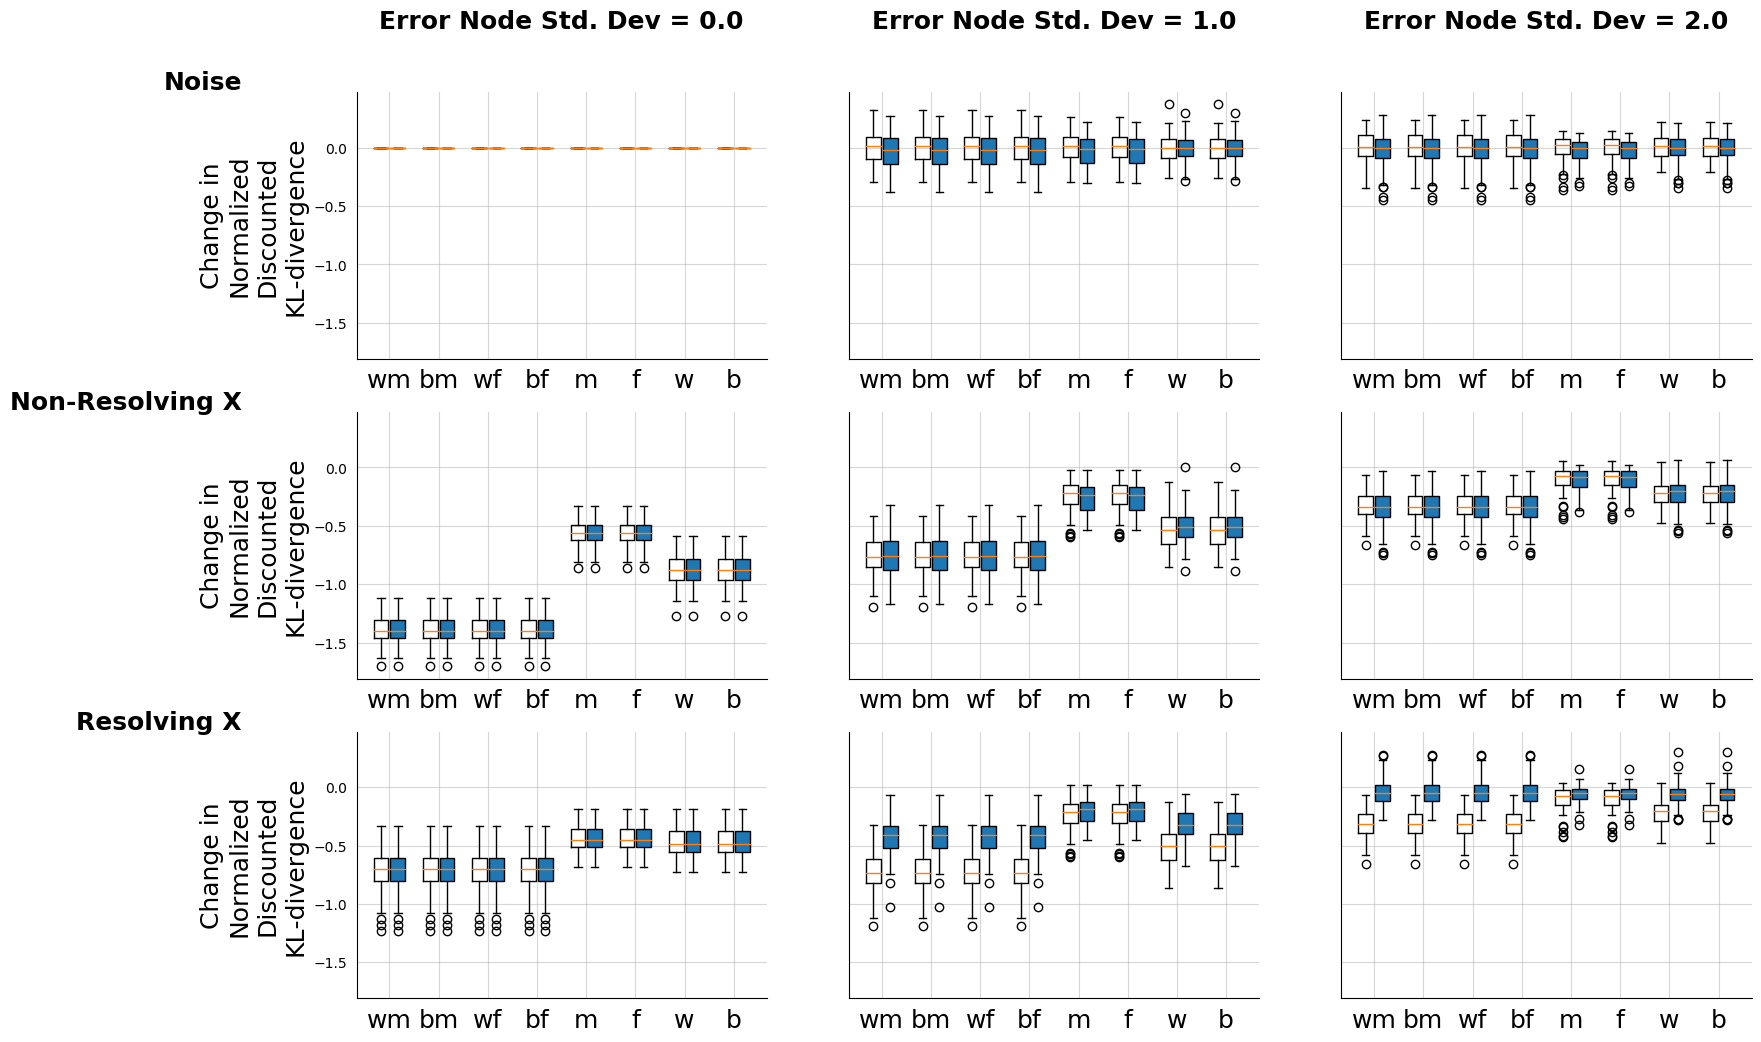

**White background: independent error terms**

**Blue background:  perfectly correlated error terms**

In [8]:
metric_boxplots(metrics[2], err_sds, id_groups, groups_dir)

#### Question on rKL: 
    
- Why does this go below -1? Isn't rKL on a [0,1] scale? Does this indicate a mistake in the way these are being calculated?